In [188]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#pip install emoji
#pip install VaderSentiment
from emoji import UNICODE_EMOJI
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#from google.colab import drive
from textblob import TextBlob
from textblob import Word
import re
#upload files
#from google.colab import files
#uploaded = files.upload()

In [189]:
full = 'full.csv' 
df = pd.read_csv(full)

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88557 entries, 0 to 88556
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   handle          88557 non-null  object
 1   name            88554 non-null  object
 2   content         88557 non-null  object
 3   replies         88557 non-null  int64 
 4   retweets        88557 non-null  int64 
 5   favorite        88557 non-null  int64 
 6   unix_timestamp  88557 non-null  int64 
 7   date            88557 non-null  object
 8   url             88557 non-null  object
 9   search_url      88557 non-null  object
 10  hashtags        21153 non-null  object
dtypes: int64(4), object(7)
memory usage: 7.4+ MB


In [191]:
df.describe()

,replies,retweets,favorite,unix_timestamp
count,88557.000000,88557.000000,88557.000000,8.855700e+04
mean,2.169574,2.356787,14.384916,1.575193e+12
std,64.085831,210.675152,527.727310,1.619700e+10
min,0.000000,0.000000,0.000000,1.551399e+12
25%,0.000000,0.000000,0.000000,1.561934e+12
50%,1.000000,0.000000,0.000000,1.572603e+12
75%,1.000000,0.000000,2.000000,1.584476e+12
max,13313.000000,57166.000000,125055.000000,1.614556e+12


In [192]:
comments = df.query('handle != "@Delta"', inplace= False)
comments = comments.drop(columns = ['search_url', 'url', 'replies', 'retweets', 'unix_timestamp', 'hashtags'], axis=1)
comments.head()

,handle,name,content,favorite,date
0,@iamlegaci,Legaci,Smh i can’t even call @Delta for customer assistance on a flight!!! Its a damn shame!,0,11 Jun 2020
1,@babautatj,Babz,Tough times...AC Systems (Fans) on this @Delta flight ain’t working 😭😭 cue the sweat and safety instruction fans 😂,0,12 Oct 2020
2,@Moxamama,Marcella H.,.@Delta you claim to support the #Blacklivesmatter movement but you donate thousands of $$ to racist politicians like @KLoeffler and @Perduesenate. That hypocrisy isn’t cool!,1,03 Dec 2020
3,@chasingshores,🗝Keyblade Queen™🗝,"Hiiii @Delta. It’s currently 12:53 AM on the east coast, and I stayed up to receive a callback from your customer service line after they said I had a 9 hour wait at 3:30 PM. I understand that you must be very busy, but can I have a little help here?",2,25 May 2020
4,@ClaraToneRecord,ClaraToneRecordsTeam,"#FlightTip Now internal us flights have entertainment like the international ones, @Delta you sly fox, I can't stay mad at you.",0,10 Jun 2020


In [193]:
comments = comments.drop_duplicates()

In [194]:
# brief clean up
def preprocess(comment):
    comment = comment.str.replace("\n", " ") # remove new lines 
    return comment

comments['content'] = preprocess(comments.loc[:,'content'])

In [195]:
#make sure we only have relevant tweet times
comments = comments.sort_values(by='date',ascending=True)
comments['date'] = pd.to_datetime(comments['date'])
datefilter = '01-01-2019'
comments = comments[comments['date'] > datefilter]
comments.head()

,handle,name,content,favorite,date
87460,@cardsaimee,Aimee Huffstetler,What’s the average time a ✈️ can be held up for maintenance be4 there should just be a new ✈️ ? #4hours #beenupsince4 #cranky @Delta,0,2019-04-01
84806,@ykhong,YK Hong,"A friendly tip @delta, I know you’re all going to adapt gender neutral options when booking, but it’s also important to catch up your staff with the “sirs” and “ma’am” restrictions. As a #DeltaDiamond, that’s one of my constant challenges.",1,2019-04-01
81603,@BrandonTWebb,Brandon Webb,39 minute call wait time for the VA. They must share the same call center as @Delta #poorcustomerservice,8,2019-04-01
84820,@dljenks84,DJ,"So @Delta, please help me to understand why your baggage counter at CHS is not manned? This is the THIRD time I’ve been here today for my baggage, that I paid $70 to have checked, just to be given the runaround. Not to mention my 4 month old is crying hysterically in the car.",0,2019-04-01
88178,@BobKnightTweet,Bob Knight,"Signs of life at #LGA at @Delta — system rebooted and flights starting to move. Only 20 min delay. All in all, could’ve been much worse.",1,2019-04-01


In [196]:
#let's clean up the apostrophes so we have consistent formatting throughout.
clean_text = []
for sentence in comments.content:
    new = sentence.replace(r"'", r"’")
    clean_text.append(new)
print(clean_text[0:10])

['What’s the average time a ✈️ can be held up for maintenance be4 there should just be a new ✈️ ? #4hours #beenupsince4 #cranky @Delta', 'A friendly tip @delta, I know you’re all going to adapt gender neutral options when booking, but it’s also important to catch up your staff with the “sirs” and “ma’am” restrictions. As a #DeltaDiamond, that’s one of my constant challenges.', '39 minute call wait time for the VA. They must share the same call center as @Delta #poorcustomerservice', 'So @Delta, please help me to understand why your baggage counter at CHS is not manned? This is the THIRD time I’ve been here today for my baggage, that I paid $70 to have checked, just to be given the runaround. Not to mention my 4 month old is crying hysterically in the car.', 'Signs of life at #LGA at @Delta — system rebooted and flights starting to move. Only 20 min delay. All in all, could’ve been much worse.', 'Just ordered my (completely insufficient) amazon gift card from @delta and the confirmation

In [197]:
comments['content'] = clean_text

In [198]:
#more data cleaning, getting rid of mentions, urls and tags to regularize character length etc.
#lower_text = [i.lower() for i in comments.content]
nourl= [] 
for i in comments.content:
    new_token = re.sub(r"http\S+" , "", i)
    nourl.append(new_token)
         

In [199]:
print(len(nourl), len(comments.content))

88422 88422


In [200]:
comments['content'] = nourl

In [201]:
#keep people mentioning Delta
delta = []
for i in comments.content:
    new_token = re.sub(r"@delta|@Delta" , "Delta", i)
    delta.append(new_token)
comments['content'] = delta

In [202]:
nomentions= [] 
for i in comments.content:
    new_token = re.sub("@" , "", i)
    nomentions.append(new_token)
nomentions 

['What’s the average time a ✈️ can be held up for maintenance be4 there should just be a new ✈️ ? #4hours #beenupsince4 #cranky Delta',
 'A friendly tip Delta, I know you’re all going to adapt gender neutral options when booking, but it’s also important to catch up your staff with the “sirs” and “ma’am” restrictions. As a #DeltaDiamond, that’s one of my constant challenges.',
 '39 minute call wait time for the VA. They must share the same call center as Delta #poorcustomerservice',
 'So Delta, please help me to understand why your baggage counter at CHS is not manned? This is the THIRD time I’ve been here today for my baggage, that I paid $70 to have checked, just to be given the runaround. Not to mention my 4 month old is crying hysterically in the car.',
 'Signs of life at #LGA at Delta — system rebooted and flights starting to move. Only 20 min delay. All in all, could’ve been much worse.',
 'Just ordered my (completely insufficient) amazon gift card from Delta and the confirmation 

In [203]:
comments['content'] = nomentions

In [204]:
notags= [] 
for i in comments.content:
    new_token = re.sub(r"#\S+" , "", i)
#    if not new_token == u'':
    notags.append(new_token)

In [108]:
import demoji
demoji.download_codes()

... OK (Got response in 2.37 seconds)
Writing emoji data to /Users/ericabonnette/.demoji/codes.json ...
... OK


In [205]:
notags = [demoji.replace(i, " ") for i in notags]

In [206]:
comments['content'] = notags

In [207]:
sentiment_intensity_each = []
analyzer = SentimentIntensityAnalyzer()
for sentence in comments.content:
    vs = analyzer.polarity_scores(sentence)
    sentiment_intensity_each.append(vs)
comments['sentiment_score'] = sentiment_intensity_each

In [208]:
#get sentiment scores now
sentiment = SentimentIntensityAnalyzer()
sentiment.polarity_scores(comments.content[0])
comments['vader_sentiment'] = comments['content'].apply(lambda x: sentiment.polarity_scores(x))
comments['vader_comp_sentiment'] = comments.vader_sentiment.apply(lambda x: x['compound'])

In [209]:
#look at most positive comments
comments.sort_values(by=['vader_comp_sentiment'], ascending=False)[['content']].head(10)

,content
50424,"Great experience flying AUS-DTW on DL2744 today. Plane in great shape, amazing AUS Sky Club, friendly ground staff, efficient boarding, and great cabin crew - esp lead attendant Sierra, who was happy, helpful, kind, and efficient. Fabulous job Delta!"
87297,"Had a great flying experience with Delta last week! From the helpful, pleasant staff to the nice variety of snacks (gluten free too!!). The best part though was all the free in flight entertainment, messaging and plugs. Impressive! Nice surprise. Thanks Delta"
60132,"I’ve always flown another major carrier loyally but this last trip I used Delta and honestly I am so glad. The staff were super friendly, we were diverted last flight due to weather & they kept us updated constantly. I love the free wifi messaging feature as well. Overall 10/10"
63599,"I’m so lucky to have friends, period, but especially to have the friends I have. I feel blessed every time I’m able to see them and spend time with them and share a meal and some booze with them. God is good. Delta is good. JetBlue is great. I’ll always appreciate this."
65296,Woke at 130am and saw msg on phone that flight was canceled so called Delta & got on earlier flight. No more sleep!. But the flight attendants on so wonderful & cheerful & made it a great day. Thanks! You guys are the best! Delta lucky to have you & so are passengers!
18384,"Dear Delta thank you so much! You’ve been awesome and gracious during the really appreciate you (Chris who I was lucky enough to chat with via messaging was supremely effective, really great with helping us with rebooking!)"
25001,"We often take to Twitter to complain but we should remember to give a huge shout out to POSITIVE things in life! Like the amazingly positive, fun & thoughtful flight attendants on my Delta flight tonight 1759 from Vegas to Boston. Had a chat w/ one & she deserves a raise :)"
2772,Kudos to Delta for their many fantastic phone agents. I called today to change a flight and found the entire experience pleasant and easy. The phone agent was super nice and proactive about looking for the best options for me. Great job!
45024,Twitter often highlights bad service but good service deserves applause. Delta your Detroit based crews make coming home easier. Flight 133 from Amsterdam was bumpy today but a good crew was calm and friendly and kept us safe. Kudos!
53228,Dear Delta Thanks for getting me home safely. Thanks for keeping us updated on some minor delays for maintenance. Thanks for taking care of my baggage so my hands could be free. Thanks for connecting me to my great friends this weekend. TNChapterACS


In [210]:
#look at most negative comments
comments.sort_values(by=['vader_comp_sentiment'], ascending=True)[['content']].head(10)

,content
19397,i refuse to ever fly Delta again. first they fuck up my flights without notice so my first flight lands at 1130 but my connecting leaves at 10?????? then I call to cancel and they fucking hang up! fuck delta fuck delta fuck delta fuck delta fuck delta fuck delta fuck delta
51749,I HATE YOU Delta I HATE YOU I HATE YOU!! You have made this day a nightmare beyond believe and forced me to chase down random gate agents to tell me I have to sleep in an airport with no food. I HATE YOU I HATE YOU. NEVER AGAIN AmericanAir I am sorry!
80819,I love Delta but today we have broken up! Pure hell & disrespect! I am heartbroken & disappointed!
4175,"What the hell is wrong with GovKemp? He is pathologically stupid and utterly incapable of leading. Fuck every single one of these worthless, gutless, cowardly bags of shit. PS, not flying on Delta until masks are allowed at Hartsfield."
54089,"Attention passengers on Delta flight 2855 you’re plane is all fucked up and shit. We are trying to fix it but your flight is delayed by 20minutes Passengers: ""WHAT THE HELL!"" ""I WANT FREE SHIT!"" ""20 MINUTES! WHAT!"" ""UGH SERIOUSLY?!?!?"""
73291,This is the reason why I don’t fly anything but Delta AmericanAir I’m sorry. But. Yaw struggle. Both flights delayed. The first delay made me miss my second delay. And the line is CRAZY LONG FOR ALL THE OTHER FOKES THAT GOT THEIR FLIGHTS DELAYED AND MISSED!
64455,Hey Delta I’ve been screwed around all damn day. Delay after delay. Disappointment after disappointment. NOT turning on the freaking air until the pilot arrives has got to be the biggest insult. We are dying on this damn hot plane after waiting all day to get on it.
19500,All aboard this Delta flight have a negative PCR test. Only way we could board. BUT we still must keep our masks on at all times...even with our proof of vax or negative covid test. So they just want us to PRETEND we’re all sick! This SCAM is what is truly sick.
51330,"Ok seriously Delta that was possibly the worst upgrade and flight I’ve been on - girl was rude as hell, crushed my bag into a tiny and vile overhead space, now I’m just waiting to see if my laptop is broken see and it’s actually bigger than ur damn over head."
69376,Feeling very angry today. Fuck Alabama and forced birthers. Fuck lyft for not taking the safety of its customers seriously. Fuck Delta for their anti-union bullshit.


In [218]:
#now to get textblob sentiment to compare results
comments['textblob_polarity'] = comments['content'].map(lambda text: TextBlob(text).sentiment.polarity)
comments['comment_len'] = comments['content'].astype(str).apply(len)
comments['word_count'] = comments['content'].apply(lambda x: len(str(x).split()))

In [219]:
# most positive comments
comments.sort_values(by=['textblob_polarity'], ascending=False)[['content', 'textblob_polarity']].head(10)

,content,textblob_polarity
37941,"Dear Delta, one of your flight attendants, Cory, is on his way to Sydney to celebrate his birthday. I know because I met him in the LAX airport and bought him a drink before he headed out. He’s a wonderful rep of your company. You should know.",1.0
25195,Delta what’s the best way to try to cancel/get a refund for a trip? Phone or DM?,1.0
60651,Thank you Delta for giving me the best reason not to use your service with your anti-union BS.,1.0
20905,The Delta SkyClub at Narita Airport is great!,1.0
78272,Thank you Delta Airlines!!! Customer service was amazing!!! You have a return customer in the Russell Family!!!!,1.0
50971,Best thing Delta ever created was these boarding class signs/lanes. Organize the humans,1.0
20538,Kudos to Donald at CVG for some awesome customer service at check-in today. Delta,1.0
84529,Shoutout to Roadie and Delta for having my luggage delivered! Great service!,1.0
48884,"Hey Delta flight DL 1444 seat 15A the entertainment system doesn’t work, awesome flight though!!",1.0
45347,HUGE shout out to Chanelle in customer service Delta’s Atlanta office for her help & kindness! She turned my day all the way around & saved my vacation too! THANK YOU!!!,1.0


In [220]:
# most negative
comments.sort_values(by=['textblob_polarity'], ascending=True)[['content', 'textblob_polarity']].head(10)

,content,textblob_polarity
69818,".Delta: horrible flights happen, but horrible customer service shouldn’t. Can you help with my hotel reimbursement?",-1.0
30632,.united is the worst! 35 minutes on hold! It’s time to switch to Delta or JetBlue!,-1.0
52312,Oh Delta shocking. Another delay,-1.0
73896,Just hanging out on the tarmac at because what else would you do? Worst airport Delta,-1.0
47119,Worst goddamn airline ever. Delta,-1.0
72291,Spend $$$$ on bus class seats and Delta goes your flights are in Amsterdam but don’t know when or what flight they are leaving on to get to you. Pathetic!!! Traveling with babies and no diapers.,-1.0
2536,Awful customer service Delta I have called for 3 days,-1.0
17641,Just had the worst experience at the airport TheeEmVee let’s never flight Delta,-1.0
42469,how is this lounge so bleak? Delta flyLAXairport,-1.0
30240,Hey Delta! Let me buy a damn plane ticket! I’ve been trying for 4 1/2 hours. Get your crap together!,-1.0


In [221]:
#look at neutral scores
textblob_neutral = comments.query('textblob_polarity == 0').rename(columns={"content": "textblob_comment"})[['textblob_comment']].reset_index(drop=True)
vader_neutral = comments.query('vader_comp_sentiment == 0').rename(columns={"content": "vader_comment"})[['vader_comment']].reset_index(drop=True)
vader_neutral

,vader_comment
0,What’s the average time a can be held up for maintenance be4 there should just be a new ? Delta
1,Hi Delta we are dealing with an issue transferring some skymiles. Is there someone I can talk to about this?
2,Being held captive on a Delta flight with sarabeth127 and BruceAshford. Will we ever make it to Indy for
3,Hey Delta I cannot find a flight reservation that I booked for someone else FOR THE LIFE OF ME. It’s not in my SkyMiles but I see the transaction in my bank account. Helpppp
4,"If you are flying Delta shuttle today, you are not going anywhere! Republic airways has a computer glitch and it can’t take off"
...,...
11448,Countdown is officially on! Taking NeringaMR for our 10 year wedding anniversary trip (and her 40th birthday ) from Brussels via JFK to Vegas tomorrow morning. First time flying with Delta - lets see what that brings!
11449,"Here we go again Delta. Setting at the gate, 15 minutes after boarding was supposed to start and the crew just arrived."
11450,My Delta pilot from SLC to SAN is not messing around with mask enforcement this morning
11451,Just boarded Delta. Why don’t they make people cover their nose? Person in front of me has her nose uncovered.


In [222]:
# which tweet has the most number of favorites
pd.set_option('display.max_colwidth', None)
comments.sort_values(by=['favorite'], ascending=False)[['content']].head(10)

,content
76144,"Excuse me Delta but this is outrageous. I just got sucked through the toilet hole in one of your aircrafts and am now hurtling through the sky, can I get my money back? This never happens on Southwest."
63399,I weigh 124 lbs. I travel with a suitcase that is 35lbs & paid 30$ to check it in. Flight now delayed bc steward needed to find a person small enough (me) to sit next to the LITERAL 450 lb man who *needs* someone to forfeit 1/3 of their seat for his spillover. I’m IRATE Delta.
14817,I just got banned from Delta for posting a picture. Wow.
61825,"Was just harassed by a Delta gate agent for carrying a TSA-approved breast pump on the plane. Something I do often w no issue. He tried to take it 3x so I nicely explained. Then he says this: “Well, where is your baby?” Well, sir, perhaps you haven’t met a working mom before."
61628,"I would like to announce that Delta Airlines has reached out & they said they would like to cover my entire trip to my last two states, Alaska and Hawaii so I can finish off my 50 state Thank You For Your Service for our veterans. Thank you Delta !"
44729,On a flight and noticed Delta cut the gay love scenes out of rocketmanmovie. Censoring LGBTQ love stories/intimacy is highly problematic and super disappointing.
7273,".Delta, JetBlue, SouthwestAir and United are offering free travel to New York for COVID-19 medical workers. They will help transport the thousands of Americans who have volunteered to serve in NY state’s surge healthcare force. Thank you from a grateful state!"
62130,I fucking did it. Got to the airport at 10:15 for a 10:30 flight. Fun fact Delta does a cool thing they take your boarding pass off your phone if youre not scanned in at the airport 30 minutes prior to departure but ya girl been burned before she took a screen shot. I am perfect
7109,Tip of the cap Delta They kicked two morons off a flight that refused to wear a mask. They have also banned 100 + other morons permantely for the same idiocy. Think I’ll book some more flight today w Delta
26578,"Flying .Delta today. Pete, if you’re in the cockpit, please make better decisions flying than you did on this season of the bachelor, much appreciated"


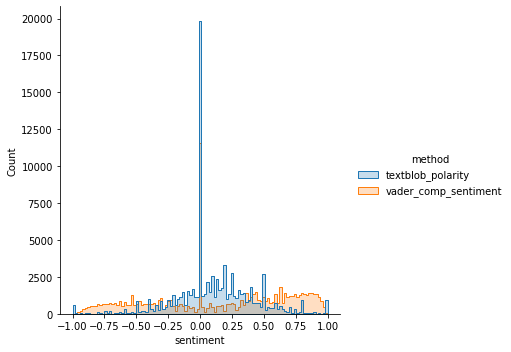

In [223]:
# comparison of textblob and vader sentiment distribution
sub = comments[['content', 'textblob_polarity', 'vader_comp_sentiment', 'date', 'handle', 'comment_len', 'word_count']]
pol_hist = sub.melt(id_vars=['content', 'date', 'handle', 'comment_len', 'word_count'], value_vars=['textblob_polarity', 'vader_comp_sentiment'], var_name='method', value_name='sentiment')
sns.displot(pol_hist, x="sentiment",hue="method", element="step")

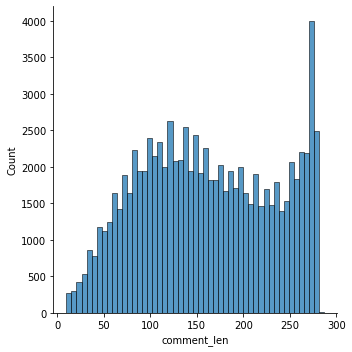

In [217]:
# comment_len, what is the most common length of tweets?
only_textblob = pol_hist.query('method == "textblob_polarity"')
only_vader = pol_hist.query('method == "vader_comp_sentiment"')
sns.displot(only_textblob, x="comment_len")

In [226]:
#Get top ten most tweeted days
comments['date'].value_counts()[:10]

2020-03-12    924
2020-03-13    688
2019-07-20    572
2019-07-19    440
2020-03-11    410
2019-06-09    405
2019-08-08    395
2019-05-10    387
2020-03-16    383
2019-07-18    345
Name: date, dtype: int64

In [227]:
#get dates with the highest and lowest average sentiment
comments.groupby('date', sort=False)['vader_comp_sentiment'].mean().idxmax()

Timestamp('2020-04-05 00:00:00')

In [228]:
comments.groupby('date', sort=False)['vader_comp_sentiment'].mean().max()

0.4810823529411761

In [229]:
comments.groupby('date', sort=False)['vader_comp_sentiment'].mean().idxmin()

Timestamp('2020-12-04 00:00:00')

In [230]:
comments.groupby('date', sort=False)['vader_comp_sentiment'].mean().min()

-0.30613176470588244

it looks like april 5th 2020 is the best sentiment day and december 12 2020 is the worst day. Let's explore the most common words used on those days

In [272]:
#make a dataframe of just the most negative dates and one of just the most positive dates 
worstday= comments.loc['2020-12-04 00:00:00']
bestday = comments.loc['2020-04-05 00:00:00']

In [286]:
maydip = comments.loc['2020-05-05 00:00:00': '2020-07-05 00:00:00']
maydipbad = maydip[maydip['vader_comp_sentiment'] < 0]
decdip = comments.loc['2020-12-01 00:00:00': '2021-01-01 00:00:00']
decdipbad = decdip[decdip['vader_comp_sentiment'] < 0]
predip = comments.loc['2019-05-01 00:00:00': '2019-09-01 00:00:00']
predipbad = predip[predip['vader_comp_sentiment'] < 0]

How many most common words to print: 20

OK. The 20 most common words are as follows

call :  331
service :  265
hey :  253
refund :  243
trying :  232
hours :  230
cancel :  219
back :  204
cancelled :  204
can’t :  199
time :  197
phone :  196
hold :  181
still :  180
days :  159
 :  137
online :  126
need :  125
even :  123
trip :  120


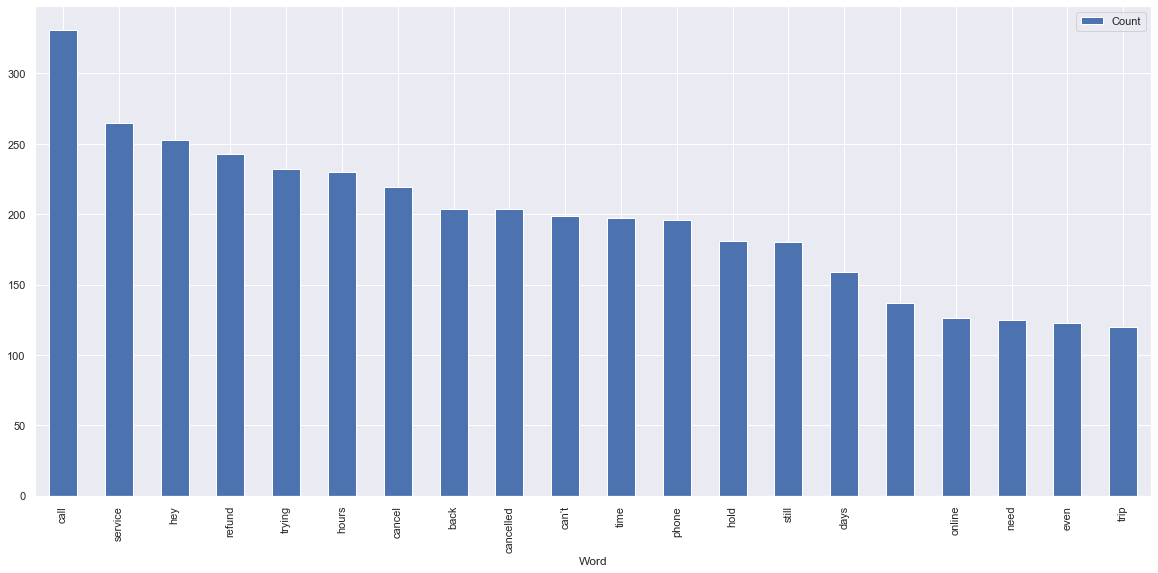

In [281]:
safelist = []
for sentence in maydipbad.content:
    safelist.append(sentence)
    
sent_str = ""
for i in safelist:
    sent_str += str(i) + " "
sent_str = sent_str[:-1]

import collections
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
from nltk.corpus import stopwords
sw = stopwords.words("english")
othercommonwords = ['it’s', 'i’ve', 'i’m', 'two', '&', 'flights','airline','@southwestair', "i'm", 'one', 'passenger', '-', ' ', '@united', 'don’t' "@delta",'@delta', "safety", "safe", "flight", "delta", "thank", "passengers" , "& ", "fly" , "@americanair" , "people" , "us" , "flying" , "get" , "like", "airlines", "plane", "air", 'don’t', "fly", 'flight', 'covid', 'distancing', 'coronavirus', 'deltaairlines', 'wearamask', 'masks', 'attendants', 'safetyfirst', 'passengers', 'sanitizer', 'customer', 'bastian', 'covidiots', 'flydelta', 'shoutout', '@mchooyah','airtravel', 'keepclimbing']
sw = sw + othercommonwords
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in sent_str.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in sw:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

In [285]:
safelist = []
for sentence in decdipbad.content:
    safelist.append(sentence)
    
sent_str = ""
for i in safelist:
    sent_str += str(i) + " "
sent_str = sent_str[:-1]

import collections
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
from nltk.corpus import stopwords
sw = stopwords.words("english")
othercommonwords = ['it’s', 'i’ve', 'i’m', 'two', '&', 'flights','airline','@southwestair', "i'm", 'one', 'passenger', '-', ' ', '@united', 'don’t' "@delta",'@delta', "safety", "safe", "flight", "delta", "thank", "passengers" , "& ", "fly" , "@americanair" , "people" , "us" , "flying" , "get" , "like", "airlines", "plane", "air", 'don’t', "fly", 'flight', 'covid', 'distancing', 'coronavirus', 'deltaairlines', 'wearamask', 'masks', 'attendants', 'safetyfirst', 'passengers', 'sanitizer', 'customer', 'bastian', 'covidiots', 'flydelta', 'shoutout', '@mchooyah','airtravel', 'keepclimbing']
sw = sw + othercommonwords
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in sent_str.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in sw:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

racist :  322
stop :  248
hypocrisy :  193
campaigns :  189
bankrolling :  175
support :  137
politicians? :  132
thousands :  123
$$ :  123
politicians :  122
kloeffler :  121
donating :  118
still :  92
donate :  80
claim :  79
movement :  79
enough :  77
take :  75
that’s :  72
hate :  68


ValueError: 
$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1440x648 with 1 Axes>

How many most common words to print: 20

OK. The 20 most common words are as follows

delayed :  1584
hours :  1303
time :  1041
hey :  1038
hour :  864
service :  857
gate :  817
delay :  787
 :  759
never :  672
back :  602
2 :  602
airport :  594
today :  585
still :  572
bag :  567
first :  554
going :  535
worst :  535
got :  516


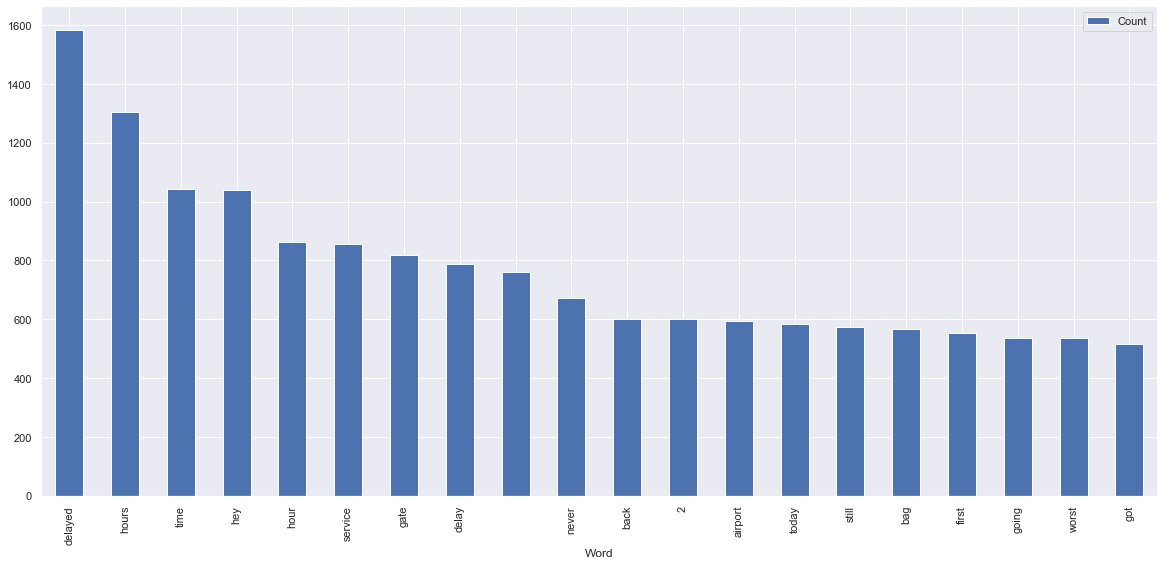

In [287]:
safelist = []
for sentence in predipbad.content:
    safelist.append(sentence)
    
sent_str = ""
for i in safelist:
    sent_str += str(i) + " "
sent_str = sent_str[:-1]

import collections
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
from nltk.corpus import stopwords
sw = stopwords.words("english")
othercommonwords = ['it’s', 'i’ve', 'i’m', 'two', '&', 'flights','airline','@southwestair', "i'm", 'one', 'passenger', '-', ' ', '@united', 'don’t' "@delta",'@delta', "safety", "safe", "flight", "delta", "thank", "passengers" , "& ", "fly" , "@americanair" , "people" , "us" , "flying" , "get" , "like", "airlines", "plane", "air", 'don’t', "fly", 'flight', 'covid', 'distancing', 'coronavirus', 'deltaairlines', 'wearamask', 'masks', 'attendants', 'safetyfirst', 'passengers', 'sanitizer', 'customer', 'bastian', 'covidiots', 'flydelta', 'shoutout', '@mchooyah','airtravel', 'keepclimbing']
sw = sw + othercommonwords
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in sent_str.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in sw:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

In [271]:
safelist = []
for sentence in worstday.content:
    safelist.append(sentence)
    
sent_str = ""
for i in safelist:
    sent_str += str(i) + " "
sent_str = sent_str[:-1]

import collections
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
from nltk.corpus import stopwords
sw = stopwords.words("english")
othercommonwords = ['it’s', 'i’ve', 'i’m', 'two', '&', 'flights','airline','@southwestair', "i'm", 'one', 'passenger', '-', ' ', '@united', 'don’t' "@delta",'@delta', "safety", "safe", "flight", "delta", "thank", "passengers" , "& ", "fly" , "@americanair" , "people" , "us" , "flying" , "get" , "like", "airlines", "plane", "air", 'don’t', "fly", 'flight', 'covid', 'distancing', 'coronavirus', 'deltaairlines', 'wearamask', 'masks', 'attendants', 'safetyfirst', 'passengers', 'sanitizer', 'customer', 'bastian', 'covidiots', 'flydelta', 'shoutout', '@mchooyah','airtravel', 'keepclimbing']
sw = sw + othercommonwords
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in sent_str.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in sw:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

racist :  51
campaigns :  34
stop :  32
hypocrisy :  28
bankrolling :  25
kloeffler :  25
politicians? :  21
support :  20
thousands :  17
$$ :  17
politicians :  17
perduesenate :  17
claim :  15
movement :  15
donate :  15
donating :  14
please :  13
that’s :  11
enough :  11
take :  9


ValueError: 
$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1440x648 with 1 Axes>

In [326]:
snacks = comments[comments.content.str.contains('snack|snacks|food|drink|beverage', regex=True)]

In [327]:
snacks.vader_comp_sentiment.mean()

snacks['Smoothed_Rolling_Sentiment_Average']= snacks.vader_comp_sentiment.rolling('30D', min_periods=1).mean()

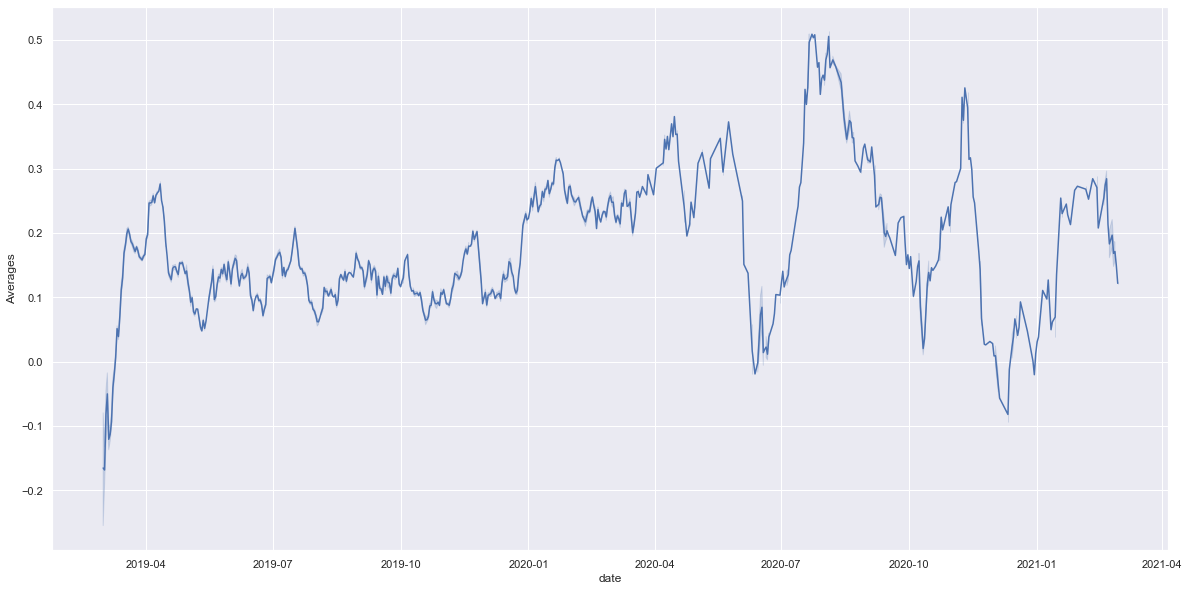

In [338]:
nusnack = snacks.drop(columns= ['word_count','handle', 'name', 'content', 'favorite', 'sentiment_score', 'vader_sentiment', 'vader_comp_sentiment', 'textblob_polarity', 'comment_len'])
snack_melted = nusnack.melt("date",var_name="bothaverages",value_name="Averages")
plt.figure(figsize=(20, 10))
sns.lineplot(data=snack_melted, x="date", y="Averages", hue="bothaverages", legend = False)

In [324]:
snackprecov = snacks.loc['2019-01-01 00:00:00': '2020-01-01 00:00:00']
snackcov = snacks.loc['2020-01-01 00:00:00': '2021-01-01 00:00:00']
print(snackprecov.vader_comp_sentiment.mean(), snackprecov.Smoothed_Rolling_Sentiment_Average.std(), snackprecov.Smoothed_Rolling_Sentiment_Average.mad())

0.13642906779661026 0.058936959444743205 0.038847977390769645


In [325]:
print(snackcov.vader_comp_sentiment.mean(), snackcov.Smoothed_Rolling_Sentiment_Average.std(), snackcov.Smoothed_Rolling_Sentiment_Average.mad())

0.23697052845528435 0.11049585284548294 0.07759816783344924


In [308]:
badsnack[7:30]

,handle,name,content,favorite,date,sentiment_score,vader_sentiment,vader_comp_sentiment,textblob_polarity,comment_len,word_count,Smoothed Rolling Sentiment Average
date,,,,,,,,,,,,
2020-06-18,@GAMSmodel,GAMS Model,"Apparently Delta isn’t only trying to cut the customer experience on (along with one partner KLM) by limiting beverage service (most competitors are not), they now are unable to not only answer the phone, if they say they’ll call you back “in 40 minutes,” it takes 2+ hours.",5,2020-06-18,"{'neg': 0.043, 'neu': 0.957, 'pos': 0.0, 'compound': -0.2732}","{'neg': 0.043, 'neu': 0.957, 'pos': 0.0, 'compound': -0.2732}",-0.2732,0.008333,276,48,0.033782
2020-06-18,@Comte_dUrgell,Comte d’Urgell,"Hello, KLM AirFranceKLM Delta. I rarely drink on flights, but there’s no excuse for an alcohol ban. You can say it’s “COVID,” but we know it’s about cutting costs, even if at significant overall expense to the customer experience. Your competitors don’t have this problem.",2,2020-06-18,"{'neg': 0.224, 'neu': 0.736, 'pos': 0.04, 'compound': -0.8741}","{'neg': 0.224, 'neu': 0.736, 'pos': 0.04, 'compound': -0.8741}",-0.8741,0.020000,275,45,-0.005691
2020-06-20,@MayaLynn8464,Maya Ruffin,"Hey Delta, you might wanna reconsider having almonds and kind bars as your in-flight snack. As someone with a nut allergy who almost went into anaphylactic shock like 4 times in my flight home just from the smell alone, I must say I am deeply disappointed.",0,2020-06-20,"{'neg': 0.146, 'neu': 0.747, 'pos': 0.107, 'compound': -0.2716}","{'neg': 0.146, 'neu': 0.747, 'pos': 0.107, 'compound': -0.2716}",-0.2716,-0.075000,257,46,0.006483
2020-06-21,@sOhollywood11,DeShawn Hollywood✨,"Oh I forgot to say Delta has CLASS! They’re still serving snacks & everything, in a very clean & sanitary way. Their attitudes are impeccable, & the customer service was superb. WHY was I ever flying w/ AmericanAir EWW! Bad attitudes, shitty service, no snacks GIRL F$K You",2,2020-06-21,"{'neg': 0.165, 'neu': 0.717, 'pos': 0.118, 'compound': -0.4197}","{'neg': 0.165, 'neu': 0.717, 'pos': 0.118, 'compound': -0.4197}",-0.4197,0.381667,274,48,0.020536
2020-06-21,@SunnySideUp333,Renee Shepherd. ☮️💟,"Flew Delta to Boston: on time, provided sanitizer, snacks & water plus usual entertainment. Return on SunCountryAir 1.25 hours late, crammed Madison flight onto MSP flight, no social distancing, no snacks or entertainment. My last flight with Sun Country.",0,2020-06-21,"{'neg': 0.151, 'neu': 0.786, 'pos': 0.063, 'compound': -0.4464}","{'neg': 0.151, 'neu': 0.786, 'pos': 0.063, 'compound': -0.4464}",-0.4464,-0.141667,255,39,0.002577
2020-06-22,@stina_says,Christina M. Muller,My 10 o’clock snack today is a pack of BiscoffCookies to pay homage since I haven’t been on a Delta jet in 5 months.,1,2020-06-22,"{'neg': 0.057, 'neu': 0.943, 'pos': 0.0, 'compound': -0.1027}","{'neg': 0.057, 'neu': 0.943, 'pos': 0.0, 'compound': -0.1027}",-0.1027,0.000000,116,24,0.032807
2020-06-30,@Vitamin_Dee1,Diana,Does Delta not give drink vouchers since there is no drink service currently in first class?,1,2020-06-30,"{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'compound': -0.296}","{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'compound': -0.296}",-0.2960,0.250000,92,16,0.091368
2020-07-03,@McChicken32,Matty Ice,Only Delta would still charge you price for delta comfort and not give you food or beverage on board and charge the same price. Something seriously wrong with this. Mask makes you hot and I can’t even get a beverage on board,0,2020-07-03,"{'neg': 0.104, 'neu': 0.842, 'pos': 0.054, 'compound': -0.3182}","{'neg': 0.104, 'neu': 0.842, 'pos': 0.054, 'compound': -0.3182}",-0.3182,-0.062500,224,42,0.116094
2020-07-05,@KBrooksMarketer,Kristi L. Brooks,"So disappointed in AmericanAir ! Full flight with NO social distancing!! Boarded front to back. status and I’ll fly Delta from now on. Flew Delta in June, back to front, snack service, hand sanitizer upon entry. Expect more from DFW-based with",1,2020-07-05,"{'neg': 0.14

How many most common words to print: 20

OK. The 20 most common words are as follows

food :  31
snacks :  16
drink :  15
mask :  13
back :  11
 :  10
class :  10
water :  10
hours :  9
eating :  9
service :  8
snack :  8
since :  7
first :  7
drinks :  7
sky :  7
middle :  7
seats :  7
got :  6
put :  6


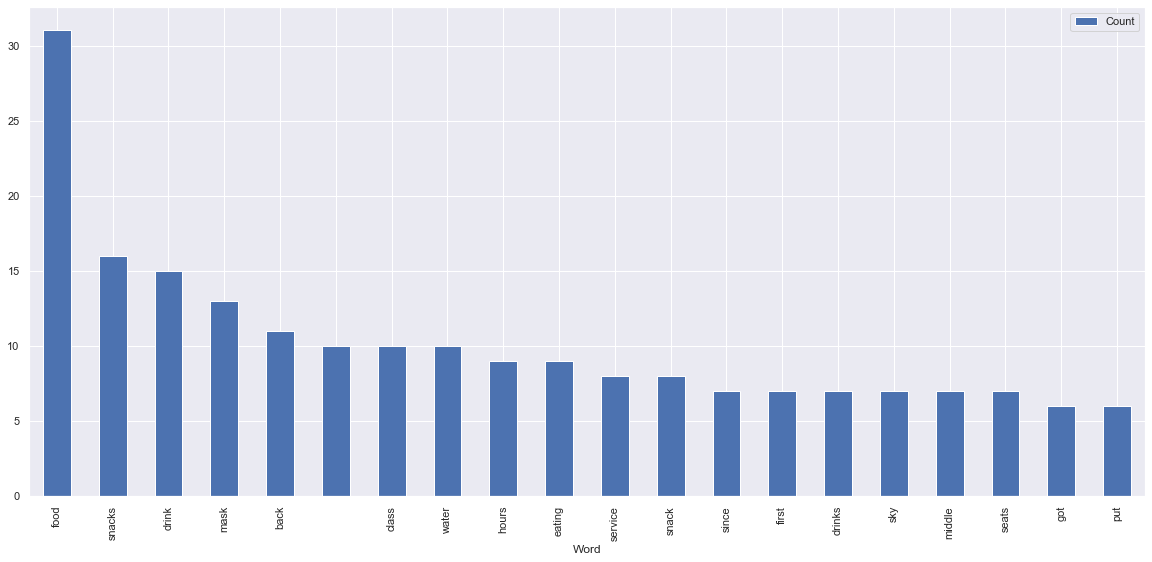

In [302]:
safelist = []
for sentence in badsnack.content:
    safelist.append(sentence)
    
sent_str = ""
for i in safelist:
    sent_str += str(i) + " "
sent_str = sent_str[:-1]

import collections
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
from nltk.corpus import stopwords
sw = stopwords.words("english")
othercommonwords = ['it’s', 'i’ve', 'i’m', 'two', '&', 'flights','airline','@southwestair', "i'm", 'one', 'passenger', '-', ' ', '@united', 'don’t' "@delta",'@delta', "safety", "safe", "flight", "delta", "thank", "passengers" , "& ", "fly" , "@americanair" , "people" , "us" , "flying" , "get" , "like", "airlines", "plane", "air", 'don’t', "fly", 'flight', 'covid', 'distancing', 'coronavirus', 'deltaairlines', 'wearamask', 'masks', 'attendants', 'safetyfirst', 'passengers', 'sanitizer', 'customer', 'bastian', 'covidiots', 'flydelta', 'shoutout', '@mchooyah','airtravel', 'keepclimbing']
sw = sw + othercommonwords
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in sent_str.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in sw:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

status :  99
2021 :  75
medallion :  58
extending :  55
email :  24
2020 :  23
year :  22
americanair :  21
extended :  20
united :  20
travel :  19
customers :  18
miles :  17
thanks :  17
hey :  17
going :  17
time :  16
current :  14
got :  14
well :  14


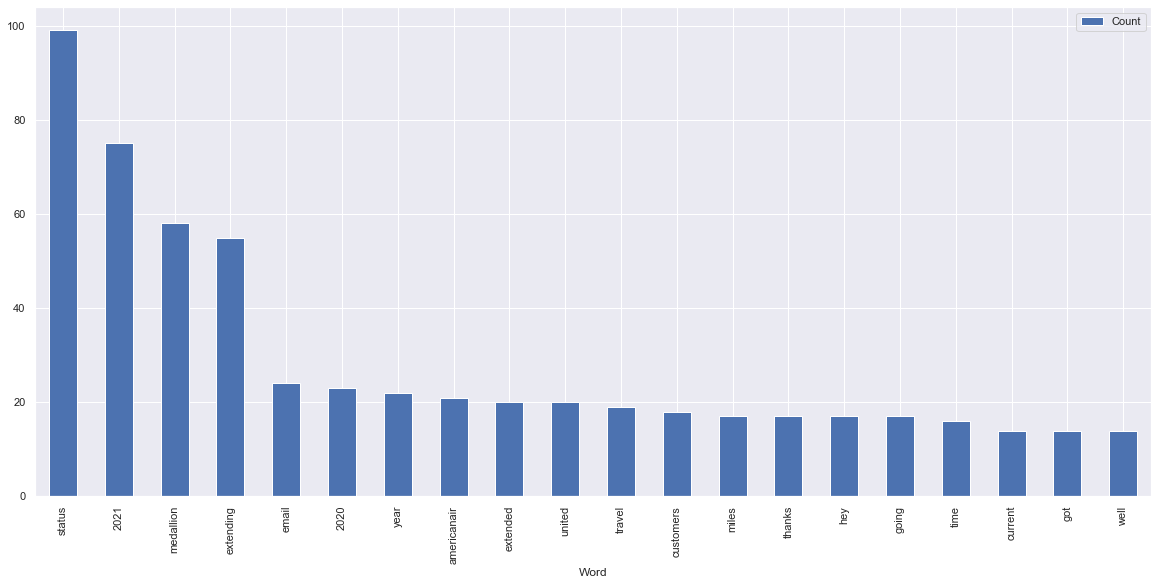

In [303]:
safelist = []
for sentence in bestday.content:
    safelist.append(sentence)
    
sent_str = ""
for i in safelist:
    sent_str += str(i) + " "
sent_str = sent_str[:-1]

import collections
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
from nltk.corpus import stopwords
sw = stopwords.words("english")
othercommonwords = ['it’s', 'i’ve', 'i’m', 'two', '&', 'flights','airline','@southwestair', "i'm", 'one', 'passenger', '-', ' ', '@united', 'don’t' "@delta",'@delta', "safety", "safe", "flight", "delta", "thank", "passengers" , "& ", "fly" , "@americanair" , "people" , "us" , "flying" , "get" , "like", "airlines", "plane", "air", 'don’t', "fly", 'flight', 'covid', 'distancing', 'coronavirus', 'deltaairlines', 'wearamask', 'masks', 'attendants', 'safetyfirst', 'passengers', 'sanitizer', 'customer', 'bastian', 'covidiots', 'flydelta', 'shoutout', '@mchooyah','airtravel', 'keepclimbing']
sw = sw + othercommonwords
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in sent_str.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in sw:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

In [270]:
# comments with highest and lowest sentiments 
# highest 
# lowest
comments.groupby('handle').mean()[['textblob_polarity']].sort_values(by=['textblob_polarity'], ascending=True)

,textblob_polarity
handle,
@DJAP187,-1.0
@dizlizy,-1.0
@dimitrykill,-1.0
@desdmitchell,-1.0
@debsells11,-1.0
...,...
@628alie,1.0
@MrThorman,1.0
@molliejanejones,1.0


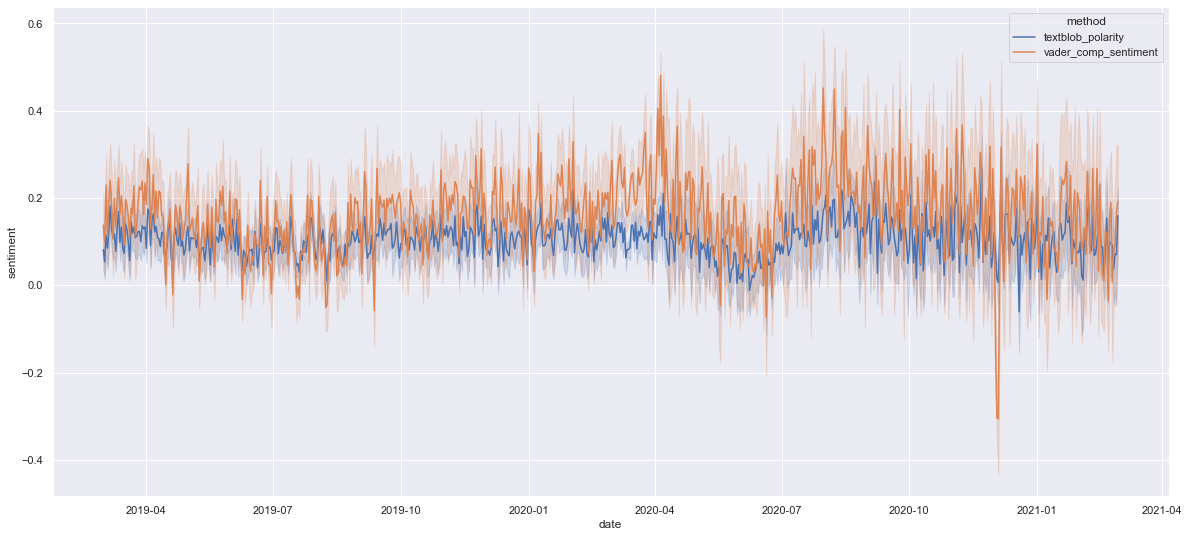

In [233]:
# sentiments over time 
sns.set(rc={'figure.figsize':(20,9)})
sns.lineplot(x="date", y="sentiment", hue="method", data=pol_hist)
# What this does show is the average scores went down overall.

In [234]:
#let's plot the moving average for the pre-covid times and the post covid just to get the overall idea
pre= '03-01-2020'
precovid= comments[comments['date'] <= pre]
precovid.reset_index(drop=True, inplace= True)
precovid = precovid.set_index(pd.DatetimeIndex(precovid['date']))
precovid = precovid.sort_index()

In [235]:
#postcovid period
postcovid= comments[comments['date'] > pre]
postcovid.reset_index(drop=True, inplace= True)
postcovid = postcovid.set_index(pd.DatetimeIndex(postcovid['date']))
postcovid = postcovid.sort_index()

In [257]:
#Get smoothed rolling averages of the sentiment
precovid['Smoothed Rolling Sentiment Average']= precovid.vader_comp_sentiment.rolling('30D', min_periods=1).mean()
postcovid['Smoothed Rolling Sentiment Average']= postcovid.vader_comp_sentiment.rolling('30D', min_periods=1).mean()

In [237]:
#get total sentiment average 
postcovid['total Average']= postcovid.vader_comp_sentiment.mean()
precovid['total Average']= precovid.vader_comp_sentiment.mean()

In [238]:
print(postcovid['total Average'][0], precovid['total Average'][0])

0.17170144980865518 0.13581167096627134


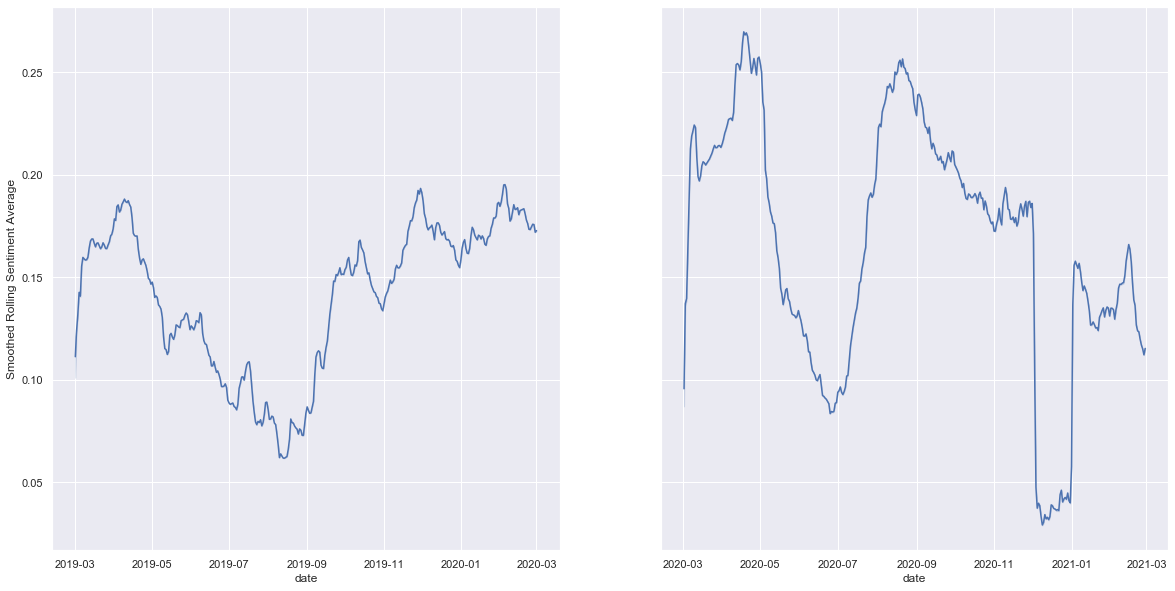

In [339]:
from datetime import datetime
fig, axes = plt.subplots(1, 2, sharex=False, sharey= True, figsize=(20,10))
sns.lineplot(ax=axes[0], data=precovid, x="date", y="Smoothed Rolling Sentiment Average")
sns.lineplot(ax=axes[1], data=postcovid, x="date", y="Smoothed Rolling Sentiment Average")
#difference of sentiment went down roughly .09, which out of the scale it is at seems fairly significant.

In [263]:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
import scattertext
import spacy.cli
spacy.cli.download("en_core_web_lg")
import scattertext as st

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [264]:
nlp = spacy.load('en_core_web_lg')

In [265]:
corpus = st.CorpusFromPandas(only_textblob, category_col='handle', text_col='content', nlp=nlp).build()
#find terms that differentiate text from background text 
print(list(corpus.get_scaled_f_scores_vs_background().index[:20]))

KeyboardInterrupt: 

In [467]:
#make new dataframe with only words using safe or safety 
safety = only_textblob[only_textblob.content.str.contains('safe|safety', regex=True)]
safety.head()

,content,date,handle,comment_len,word_count,method,sentiment
1,i think it’s safe to say i will NEVER fly with again after such TERRIBLE customer service today from a SUPERVISOR. i have never in my life spoken to someone so rude.,2019-04-01,@NicoleGamboni,166,32,textblob_polarity,-0.240000
2,So the end of that new Delta safety video...?,2019-04-01,@MezzoMiller,46,9,textblob_polarity,0.136364
8,"But of course CEO of Delta will place his smug face all over flight safety video but cower away from the President s airline summit , bceasue delta policies designer to trick and over sell flights",2019-08-01,@TNY_oldschool,197,36,textblob_polarity,0.000000
9,Always fun to have an early morning flight and get sat in a seat with a broken TV monitor. It could play the safety video but can’t load the in flight entertainment. Delta,2019-08-01,@cmoviereview,174,33,textblob_polarity,0.000000
12,Kudos to Delta for insuring passenger safety. Boarding 10 at a time to maintain social distancing. No middle sears booked. Unlike doesn’t do either.,2020-08-01,@janito50,149,24,textblob_polarity,0.016667


In [468]:
#create only negative safety now.
badsafety = safety[safety.sentiment< 0.000000]
badsafety.head()

,content,date,handle,comment_len,word_count,method,sentiment
1,i think it’s safe to say i will NEVER fly with again after such TERRIBLE customer service today from a SUPERVISOR. i have never in my life spoken to someone so rude.,2019-04-01,@NicoleGamboni,166,32,textblob_polarity,-0.240000
52,100 min and safety cards still missing. WTH,2019-07-01,@ZagEsquire,44,8,textblob_polarity,-0.200000
54,120 min Delta over freaking safety cards. Still waiting. This is horrible and really stupid.,2019-07-01,@ZagEsquire,92,15,textblob_polarity,-0.900000
55,"How do you board a plane, knowing you are lacking safety cards and thus cannot take off due FAA regulations?! Been waiting on board for over 1hr in 90F heat...Shame on you Delta!",2019-07-01,@Angiogenic,178,33,textblob_polarity,-0.195312
64,To the angry woman on my Delta flight that yelled in my face and called me the “mask police” for asking a couple slobbering all over each other to please put on masks.... i hope you still stay safe. Cause that’s the point. ✌🏻 ❤️,2020-07-01,@Leore_B,230,45,textblob_polarity,-0.041667


In [469]:
#find most common associations with content containing those words.
corpussafe = st.CorpusFromPandas(safety, category_col='handle', text_col='content', nlp=nlp).build()
# terms that differentiate text from background text 
print(list(corpussafe.get_scaled_f_scores_vs_background().index[:20]))

['covid', 'distancing', 'shoutout', 'deplaning', 'rebook', 'maskless', 'deltanewshub', 'deltalina', 'sanitizer', 'delta', 'twitter', 'ecredit', 'rebooked', 'rebooking', 'deplaned', 'deplane', 'overbook', 'tweets', 'attendants', 'bastian']


In [470]:
safelist = []
for sentence in .content:
    safelist.append(sentence)
    
sent_str = ""
for i in safelist:
    sent_str += str(i) + " "
sent_str = sent_str[:-1]


How many most common words to print: 20

OK. The 20 most common words are as follows

crew :  19
seats :  18
mask :  17
seat :  15
middle :  15
video :  14
i’ve :  14
two :  14
today :  12
time :  12
hours :  12
sitting :  12
next :  12
hey :  12
disappointed :  12
travel :  11
pandemic :  11
even :  11
hope :  10
health :  10


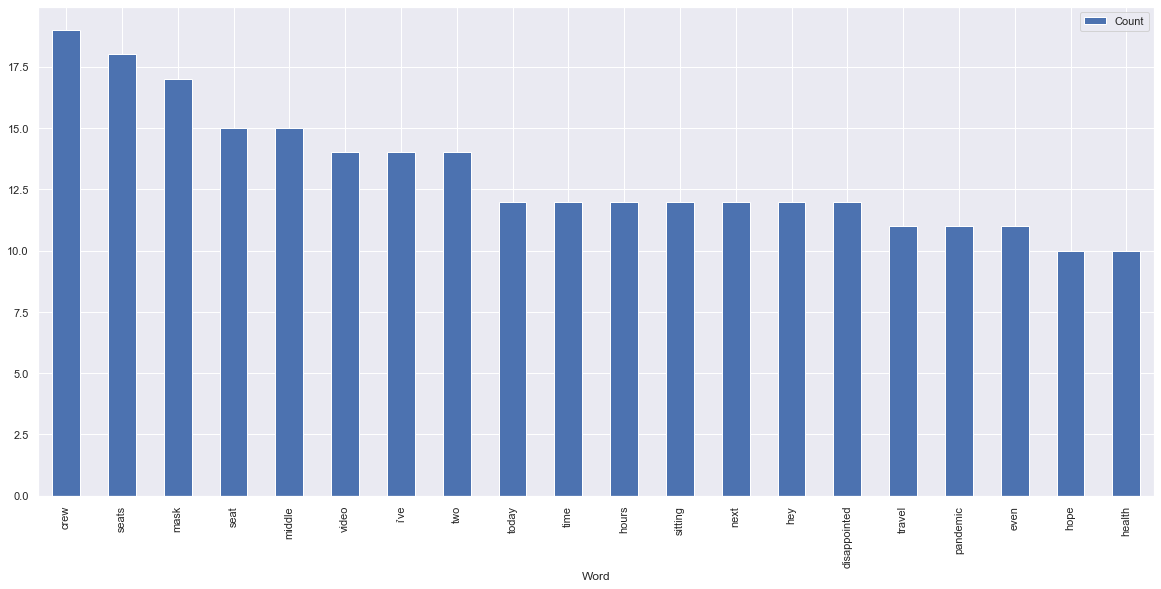

In [471]:
import collections
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
from nltk.corpus import stopwords
sw = stopwords.words("english")
othercommonwords = ['it’s', 'i’ve', 'i’m', 'two', '&', 'flights','airline','@southwestair', "i'm", 'one', 'passenger', '-', ' ', '@united', 'don’t' "@delta",'@delta', "safety", "safe", "flight", "delta", "thank", "passengers" , "& ", "fly" , "@americanair" , "people" , "us" , "flying" , "get" , "like", "airlines", "plane", "air", 'don’t', "fly", 'flight', 'covid', 'distancing', 'coronavirus', 'deltaairlines', 'wearamask', 'masks', 'attendants', 'safetyfirst', 'passengers', 'sanitizer', 'customer', 'bastian', 'covidiots', 'flydelta', 'shoutout', '@mchooyah','airtravel', 'keepclimbing']
sw = sw + othercommonwords
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in sent_str.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in sw:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

In [592]:
#display all content where seats are mentioned
badsafety[badsafety.content.str.contains('seat|seats', regex=True)]

,content,date,handle,comment_len,word_count,method,sentiment
132,"Past 24 hours flew Delta and it was such a pleasure, safe and comfortable feeling. Also flew and it was horrible. Overcrowded- every seat full and half the passengers had their masks below their noses.",2020-10-01,@mitchgould,202,35,textblob_polarity,-2.380952e-02
176,Forced to grab a last-minute flight today and appreciate hard line on masks and blocking seats for safety. You do you boo. Don’t listen to the haters. ❤️,2020-08-02,@deboone,154,28,textblob_polarity,-2.958333e-01
626,"So disappointed has opted to put profits before people, eliminating its safety protocol of empty middle seats. After Nov 1, all we’ll have left is Delta.",2020-11-04,@Jessbirdie,155,26,textblob_polarity,-2.125000e-01
745,"I’m on a Delta flight and two men seated in my row are blatantly disregarding the mask rule, playing on their phones without any sort of face covering. Flight attendants have yet to approach them reminding them of the rule. I feel unsafe.",2020-06-05,@anne_nomi,238,43,textblob_polarity,-5.000000e-01
782,"Thank you Delta for your new policies that share responsibility for COVID-19 safety between customers AND Delta: masks, spread-out seating, less passengers.",2020-05-05,@greenthoughtsmn,156,22,textblob_polarity,-1.515152e-02
874,"Grateful for Delta and their safety precautions! I was given a wipe to wipe down my seat & all middle seats are empty! 🙌🏻 (Traveling for work, not fun)",2020-07-06,@heyheychristay,151,29,textblob_polarity,-1.076389e-01
1238,"Hey Delta we’re sitting near a moron who I guess has missed the memo five months into the pandemic — you put the mask over your mouth *and* nose. Maybe incorporate basic “how to wear a mask” language into “put your seatbelt on” safety recording, etc. Thx",2020-08-09,@ChrisCarrollDC,254,47,textblob_polarity,-2.333333e-01
1262,"In a confusing interview, Delta CEO argues simultaneously that airlines shouldn’t test passengers for Covid because it won’t keep them safer, but brags about keeping middle seats clear for safety At the height of a pandemic, Bastian argues that people need to get back to life",2021-02-09,@kellygirl00,276,46,textblob_polarity,-5.000000e-02
1360,"I felt safe flying on Delta, until Delta books a stranger in the seat next to me on a flight, I discovered this after boarding, and the answer by the flight attendant was, this is a fully booked flight... Very unhappy with Delta in these days of rising cases.",2020-11-09,@theMdawg88,259,49,textblob_polarity,-2.000000e-02
1441,Flight from Charlotte to JFK on — fly them often. This is absurd. Not one empty seat on plane. They care more about $$$ than safety. Sickening. Will be going back to Delta,2021-01-10,@collinlthompson,172,33,textblob_polarity,-3.333333e-02


In [472]:
#get daily averages of text and vader, and then reset the indexes so its flattened into a dataframe that can be graphed
avg_day_type = pol_hist.groupby(['date', 'method']).mean()
avg_day_type.reset_index(level=['date','method'])

,date,method,comment_len,word_count,sentiment
0,2019-03-01,textblob_polarity,219.250000,40.000000,-0.063750
1,2019-03-01,vader_comp_sentiment,219.250000,40.000000,0.495050
2,2019-03-02,textblob_polarity,247.000000,51.000000,0.350000
3,2019-03-02,vader_comp_sentiment,247.000000,51.000000,0.735100
4,2019-03-03,textblob_polarity,175.333333,32.000000,0.307113
...,...,...,...,...,...
1403,2021-02-26,vader_comp_sentiment,219.000000,41.300000,0.095860
1404,2021-02-27,textblob_polarity,146.000000,23.000000,0.300000
1405,2021-02-27,vader_comp_sentiment,146.000000,23.000000,0.773700
1406,2021-02-28,textblob_polarity,165.000000,30.857143,0.109704


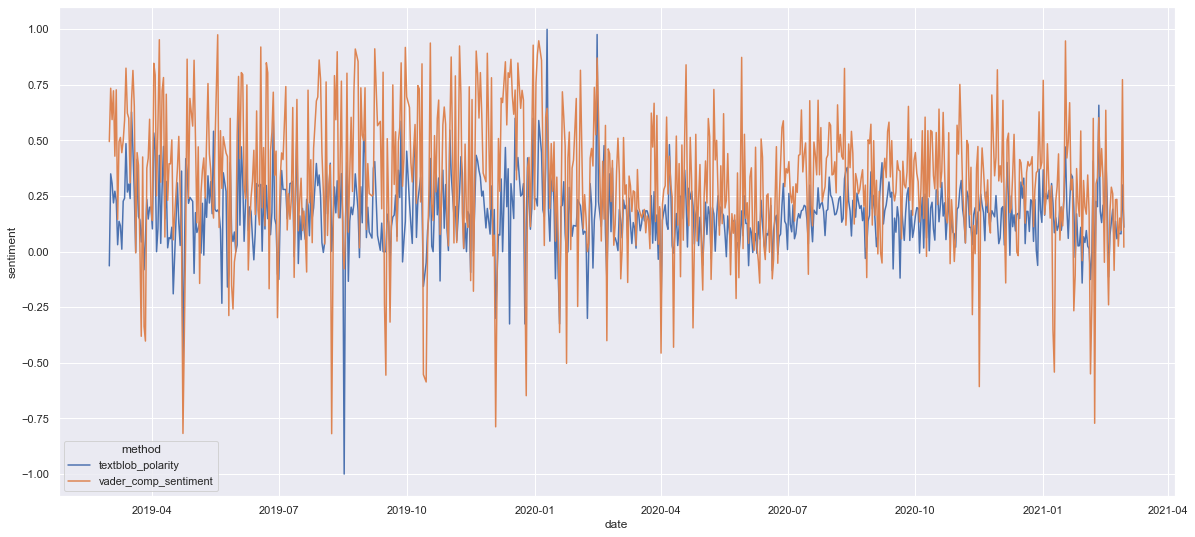

In [473]:
# plot avg daily sentiments over time 
sns.set(rc={'figure.figsize':(20,9)})
sns.lineplot(x='date', y="sentiment", hue= 'method', data=avg_day_type)